<a href="https://colab.research.google.com/github/alex-pakalniskis/GraphAdvocatesWorkshopIdeas/blob/main/Introduction_to_the_Q_Learning_Algorithm_Pakaliscious_remix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Q-Learning Algorithm

![agent, action, environment, state, reward loop](https://static.javatpoint.com/tutorial/reinforcement-learning/images/what-is-reinforcement-learning.png)


## Outline

*   Background
*   Bandits, epsilon-greedy strategy, moving averages
*   Implement Q-Learning algorithm for Markov Decision Process (MDP)



## Background

[Semiotic Labs](https://www.semiotic.ai/), a core development group within The Graph ecosystem, builds automated decision-making tools for decentralized markets on the blockchain.

![semiotic labs logo](https://static.wixstatic.com/media/b2fbb4_85e2c9666b6345c3bb766e18e4d12dcf~mv2.png/v1/fill/w_600,h_87,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/Semiotic%20Logo-02-black-transparent-bg.png)

Example tools include:
* **Indexer Allocation Optimization** to make it easier for Indexers to choose which subgraphs to index in order to maximize their profits
* **Auto Agoura** to help Indexers automatically adjust prices to be competitive in the market

Before Graph Day 2022, [Sam Green](https://twitter.com/0xsamgreen) (Head of Research and Co-Founder at Semiotic Labs) shared a Python notebook which covers the basics of [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning) with the [Q-learning algorithm](https://en.wikipedia.org/wiki/Q-learning). This notebook is an adaptation of that original work. Thanks to Sam for the inspiration.

* [Original tweet](https://twitter.com/0xsamgreen/status/1530942794142871552?s=21&t=WrmlxDSXACIhdPVs4mLfmA)
* [Original Python notebook on Google Colab](https://colab.research.google.com/drive/1M5cJafS4KvL5cTdubWVE6EKMi6BPvkGM)

In Sam's words:
> The Q-Learning algorithm is the ["hello world"](https://en.wikipedia.org/wiki/%22Hello,_World!%22_program) of RL

Let's get a bit more background about RL before we proceed.

### Reinforcement Learning

> An area of machine learning concerned with how intelligent agents ought to take actions in an environment in order to maximize the notion of cumulative reward. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning. - [Wikipedia](https://en.wikipedia.org/wiki/Reinforcement_learning)

Within the Graph ecosystem, Semiotic Labs uses Deep RL (a more advanced form of RL) to "...develop autonomous agents that can negotiate price and other terms in bilateral or auction type deals". - [semiotic.ai](https://www.semiotic.ai/)

![RL figure from semiotic.ai](https://static.wixstatic.com/media/769004_7ae28ae03bac467685d334430335ee70~mv2.png/v1/fill/w_302,h_311,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/DeepRL.png)

Now that we've set the stage with a bit of background context, let's move on.

## Bandits, epsilon-greedy strategy, moving averages

Imagine the following scenario:
*   You walk into a casino
*   Many slot machines available to play
*   You have no prior knowledge of slot machine reward probabilities
*   And a finite amount of money to play with

#### **Goal**: Discover the most profitable machine to play.

![casino mathematics](https://media1.giphy.com/media/l3fZLMbuCOqJ82gec/giphy.gif?cid=ecf05e47c6uhv98ej600w75yjkv5wbgnced1xprbh86ytz6h&rid=giphy.gif&ct=g)

This is an example of a [*multi-armed bandit*](https://en.wikipedia.org/wiki/Multi-armed_bandit) problem in the field of RL.

While many strategies to solve this problem exist, let's start with the [epsilon-greedy strategy](https://en.wikipedia.org/wiki/Multi-armed_bandit#Semi-uniform_strategies).

* Please check out [Wikipedia](https://en.wikipedia.org/wiki/Multi-armed_bandit#Bandit_strategies) for more details on other strategies.



### Epsilon-greedy strategy 
An approach that balances exploration and exploitation

![epsilon greedy strategy](https://miro.medium.com/max/1400/1*_5dltx4BcI8rRmCK2Sq_kw.png)
Tough choice Mr. Robot

> $\epsilon$-Greedy Exploration is an exploration strategy in reinforcement learning that takes an exploratory action with probability $\epsilon$ and a greedy action with probability 1-$\epsilon$. It tackles the exploration-exploitation tradeoff with reinforcement learning algorithms: the desire to explore the state space with the desire to seek an optimal policy. - [paperswithcode](https://paperswithcode.com/method/epsilon-greedy-exploration)

The struggle between trying a new restaurant and going to the usual spot. I'll be honest, I'm a creature (or agent) of habit.


An agent selects the best-known option with probability $1- \epsilon$, otherwise they select a random option. 
* epsilon is usually set low, e.g., $\epsilon < .1$.

In the context of The Graph, one could think about indexers as "greedy bandits" trying to find the optimal balance of subgraph(s) to index for rewards. Should the stick with tried-and-true subgraphs, or explore new ones?

Likewise, delegators could benefit from decision-making tools which help them balance the trade-offs of deciding where to delegate.

To start, let's set $\epsilon$ = 0.25 (a relatively high value according to the above threshold).

In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gym
from gym.envs.registration import register
import pdb
import time

epsilon = .25

random = np.random.rand()

if random < epsilon:
  print("pick a random machine (explore)")
else:
  print("pick the best known machine (EXPLOIT)")

pick the best known machine (EXPLOIT)


### Simulations
Next, let's create a Python class to assist us with modeling a multi-arm bandit scenario with slot machines. This simulation will help us build intuition around RL and Q-learning. 

![simulation puffin](https://simbound.com/uploads/blog/meme.png)

Semiotic Labs uses simulations to stress test new protocols and train AI for decentralized market participation. 

We'll call our class `SlotMachine` and declare a single method called `pull` to mimic the IRL experience of slot machine usage. 

`SlotMachine.pull()` returns a random choice of number from 5 numbers between -10 and 10.

Feel free to tinker and modify the code and make it your own as you learn. 


In [ ]:
class SlotMachine():
  """Class to mimic casino slot machine user experience"""
  def __init__(self, debug = False):
    # Sample five integers as the slot machine reward
    self.rewards = np.random.randint(low=-10, high=10, size=5)
    # Sample five numbers in range [0,1) from uniform distribution
    self.probs = np.random.rand(5,)
    # Make the sum of `self.probs` sum up to 1
    self.probs = self.probs/sum(self.probs)

    if debug == True:
      print('Creating a new slot machine with rewards:')
      print(self.rewards)
      print('and probabilities:')
      print(self.probs)
  
  def pull(self):
    """Pull lever of slot machine to return a random reward"""
    return np.random.choice(self.rewards, p=self.probs)

Let's create an instance of the `SlotMachine` class and do some exploring with it.

We'll pull the slot machine a few times and print out the results. 

In [ ]:
# Create an instance of a slot machine and pull it's lever
sm = SlotMachine(debug=True)

print(f"\nResult of SlotMachine.pull() = {sm.pull()}")
print(f"\nResult of SlotMachine.pull() = {sm.pull()}")


Creating a new slot machine with rewards:
[ 1  9  9 -7  4]
and probabilities:
[0.26619152 0.35303037 0.03814882 0.03004325 0.31258604]

Result of SlotMachine.pull() = 1

Result of SlotMachine.pull() = 1


Ok. Basically a slot machine amirite? 

![doggone lucky](https://i.imgur.com/X4fewRf.png)

Now that we've explored how to work with a single `SlotMachine` instance, let's simulate the experience of having access to multiple slot machines (just like a "power user" at a casino in Las Vegas). 
* For this example, we'll create 5 slot machines.



In [ ]:
num_machines = 5
machines = [SlotMachine() for _ in range(num_machines)]

Before we proceed, let's check to make sure our program creates SlotMachines with different rewards, probabilities, and `.pull()` return values.

In [ ]:
for machine in machines:
  print(f"Machine rewards: {machine.rewards}")
  print(f"Machine probs: {machine.probs}")
  print(f"Pull the lever: {machine.pull()}")
  print("\n")

Machine rewards: [-2  8 -2  2 -5]
Machine probs: [0.22505383 0.23680862 0.12297907 0.0310358  0.38412268]
Pull the lever: -2


Machine rewards: [-7  3  1  9  6]
Machine probs: [0.14371257 0.02498268 0.29239816 0.17267731 0.36622928]
Pull the lever: 6


Machine rewards: [ 5 -9  2 -9  5]
Machine probs: [0.05273725 0.26026146 0.30843675 0.11924965 0.2593149 ]
Pull the lever: 2


Machine rewards: [  7   3 -10   8   6]
Machine probs: [0.23342215 0.33465133 0.10368071 0.03778359 0.29046221]
Pull the lever: 6


Machine rewards: [3 9 8 3 1]
Machine probs: [0.10848108 0.38037754 0.2656443  0.23732523 0.00817184]
Pull the lever: 3




All the machines have different rewards and probabilities, so we're good to proceed.

### Moving average as a computational and storage-efficienct way to track statistics

The kind folks at [Wikipedia](https://en.wikipedia.org/wiki/Moving_average) describe **moving average** as "a calculation to analyze data points by creating a series of averages of different subsets of the full data set".

We can visualize moving averages with a list of numbers and some math. The [pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) library makes it pretty simple to calculate rolling averages (and many other stats) without any manual calculations on our part (NICE!).

I'll start by creating a list of numbers (values), convert it to a pandas DataFrame (analagous to a spreadsheet), then calculate moving averages for each record using a window size of my choice. 

In [ ]:
import pandas as pd 

values = [0, 1, 2, 1000, 4, 0, -2, 0, -9999]
df = pd.DataFrame({'Data': values})

window_size = 2
df[f"Moving average, window={window_size}"] = df.rolling(window_size).mean()


df

,Data,"Moving average, window=2"
0,0,NaN
1,1,0.5
2,2,1.5
3,1000,501.0
4,4,502.0
5,0,2.0
6,-2,-1.0
7,0,-1.0
8,-9999,-4999.5


The first record/value doesn't have a moving average since there are no prior time points. But all other records will have an associated moving average since there a prior data points in "time".

If we reorient to the multi-armed bandit problem, we can think of $reward_t$ as a new piece of information at timestep $t$. Furthermore, each step we'd update the estimate by some small step-size alpha, e.g. $0 < \alpha < 1$.

In formula notation, this version of moving average can be described as:

$MA_t = MA_{t-1} + \alpha(\underbrace{reward_t - MA_{t-1}}_\text{Temporal Difference})$

Don't worry if that's a bit daunting to internalize. It takes time. 

Now that we're getting comfortable with multiple slot machines and some statistics, let's combine the two as we progress toward solving the dilemma.

### Combining epsilon-greedy and moving averages to track value estimates of 5 machines

Let's write another class to help us run experiments and plot the results.

![experiment doggo](https://thefinchandpea.files.wordpress.com/2012/11/funny-science-news-experiments-memes-dog-science-fuzzy-logic.jpg)



In [ ]:
class Experiment:
  """Class to streamline epsilon-greedy + moving average experiments"""
  def __init__(self, epsilon, alpha, machines, num_episodes):
    self.epsilon = epsilon
    self.alpha = alpha 
    self.machines = machines
    self.num_machines = len(self.machines)
    self.num_episodes = num_episodes
    # Create an array with `num_machines` elements
    self.values = [0]*self.num_machines
    # Track the history of the values for plotting
    self.values_history = []
  
  def test(self):
    for episode in range(self.num_episodes):
      if np.random.rand() < self.epsilon:
        machine_index = np.random.randint(self.num_machines)
      else:
        machine_index = np.argmax(self.values)
      reward = self.machines[machine_index].pull()
      self.values[machine_index] = self.values[machine_index] + self.alpha * (reward - self.values[machine_index]) 

      # For plotting
      self.values_history.append(copy.copy(self.values))


  def plot(self):
    self.values_history = np.array(self.values_history)
    
    plt.figure(figsize=(8,6))
    colors = ['blue', 'purple', 'green', 'orange', 'red']

    for i in range(self.num_machines):
      plt.plot(self.values_history[:,i], label=f'M{i} estimated', color=colors[i])
      plt.axhline(self.machines[i].rewards @ self.machines[i].probs, label=f'M{i} true', color=colors[i], linestyle='--')
    plt.title(f'alpha={self.alpha} and epsilon={self.epsilon}, {self.print_policy()}')
    plt.legend(loc='lower left')
    plt.xlabel('Episode')
    plt.ylabel('Value Estimate')
    plt.plot()
  
  def print_policy(self):
    return f'policy = best action = go to machine {np.argmax(self.values)}'

  def run(self):
    self.test()
    self.plot()


# Parameters for plotting figures from results
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


To start, we'll set $\epsilon$ = 0.1 and $\alpha$ = 0.005 (small time step), create 5 new SlotMachines, and run 50000 episodes.

After the epsilon-greedy algorithm is finished, the estimated values can be viewed as a *policy*.

The policy tells us the best action to take.

![](https://www.memecreator.org/static/images/memes/5330651.jpg)

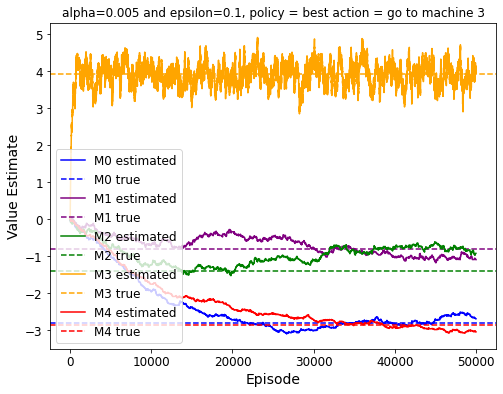

In [ ]:
machines=[SlotMachine() for _ in range(5)]

Experiment(
    epsilon=0.1, 
    alpha=0.005, 
    machines=machines, 
    num_episodes=50000).run()

Let's run the experiment on a few different values for alpha and epsilon

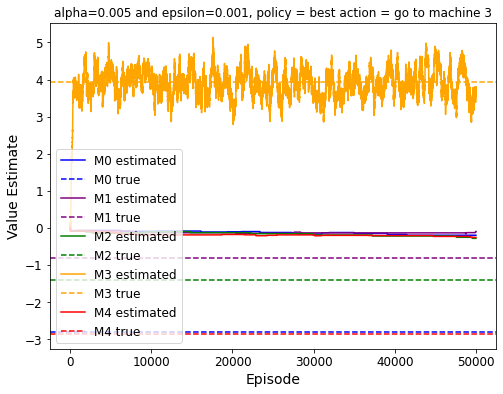

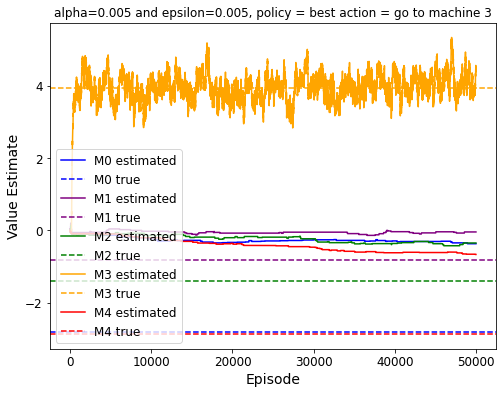

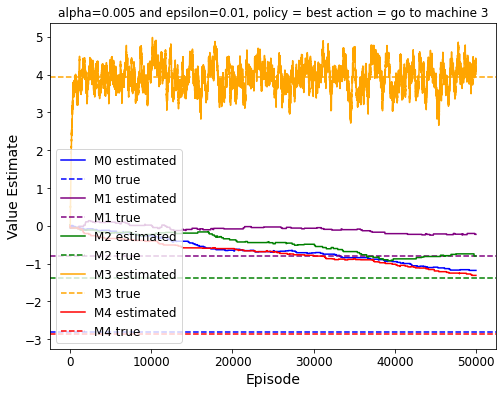

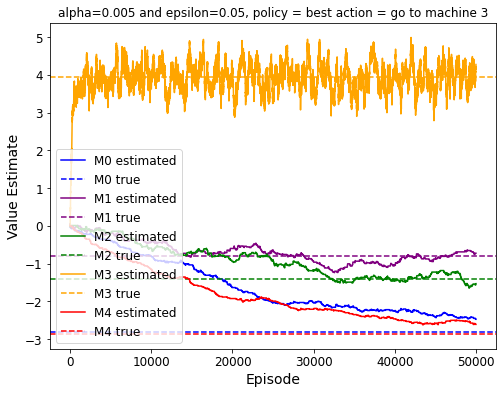

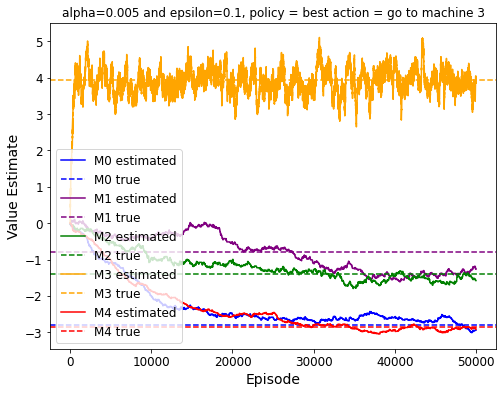

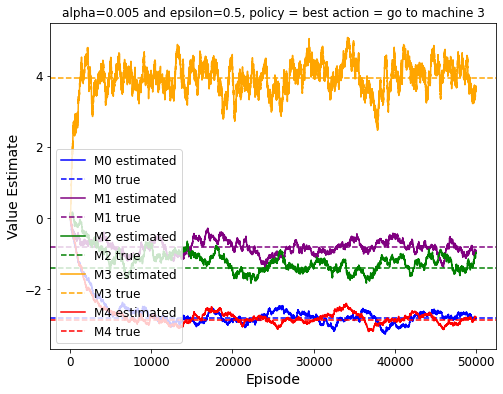

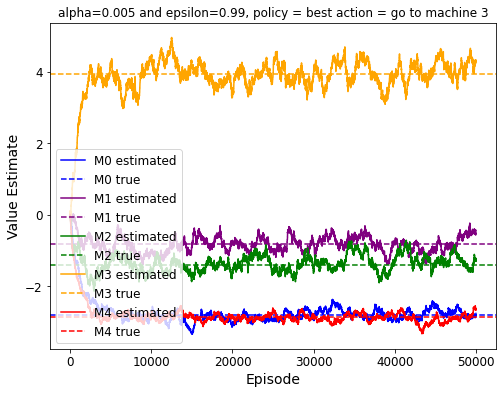

In [ ]:
epsilons = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]

for ep in epsilons:

  Experiment(
    epsilon=ep, 
    alpha=0.005, 
    machines=machines, 
    num_episodes=50000).run()

Varying $\epsilon$ while holding $\alpha$ constant yielded the same policy each time. Interesting!



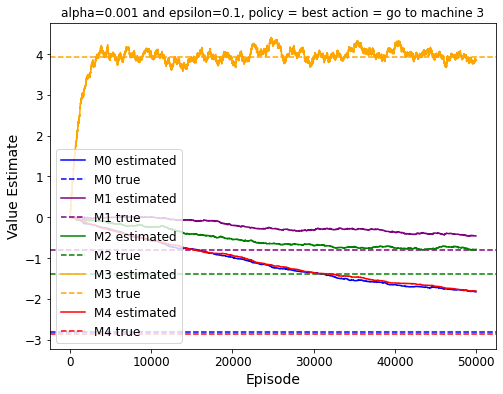

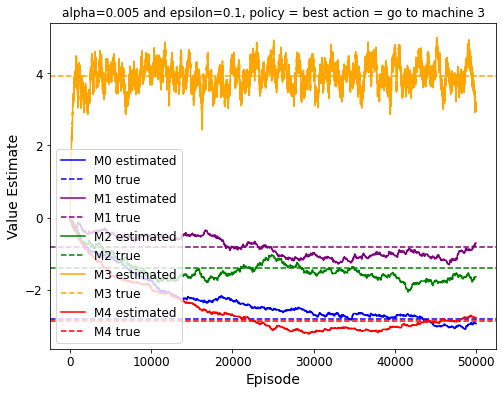

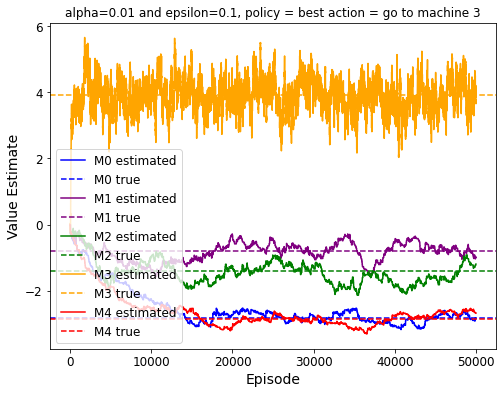

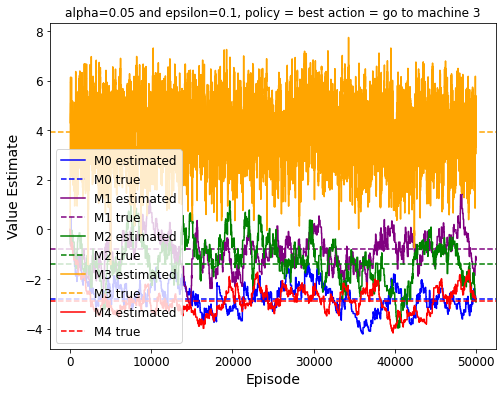

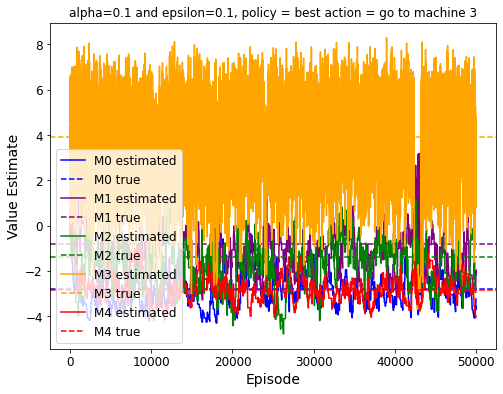

In [ ]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1]

for al in alphas:
  
  Experiment(
    epsilon=0.1, 
    alpha=al, 
    machines=machines, 
    num_episodes=50000).run()


Varying $\alpha$ while holding $\epsilon$ constant also yielded the same policy each time. Also interesting!

## Implement Q-Learning algorithm for Markov Decision Process (MDP)
![q-ute learning](https://memegenerator.net/img/instances/58507474.jpg)
### A multi-arm bandit problem is also a Markov Decision Process with a single state

![](https://memegenerator.net/img/instances/59825463.jpg)

[*Markov process*](https://en.wikipedia.org/wiki/Markov_chain) is a random process whose future state only depends on the present state (and not the past).

E.g., The probability of a specific coin sequence can be viewed as a Markov process. E.g., HHT.

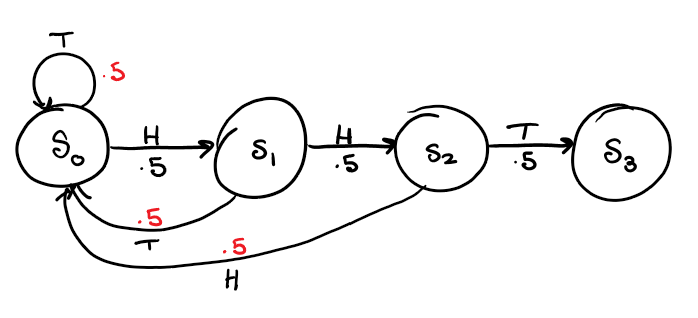

A [*Markov Decision Process* (MDP)](https://en.wikipedia.org/wiki/Markov_decision_process) is a discrete-time stochastic control process.

"Stochastic" means that different results can happen even when the same thing is done.

Below is a simple MDP with three states and two actions. $p(s_1 \lvert s_0,a_0)$ is the state transition probability function. It gives the probability of moving to state $s_1$, given that the agent makes action $a_0$ when in state $s_0$.

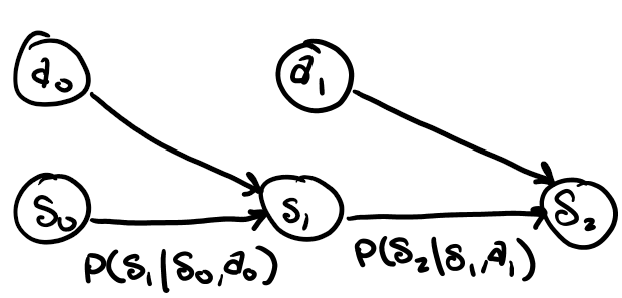

Here is the multi-armed bandit viewed as a single-state MDP. Green arrows are rewards emitted from the machine.



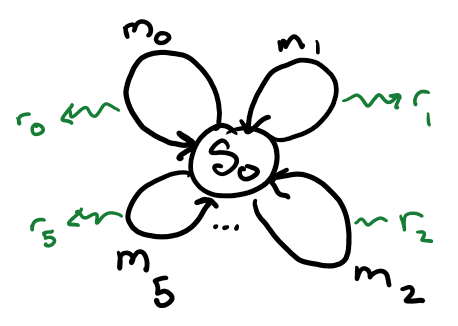

m0, m1, m2, m3, m4 are SlotMachines() with associated rewards r0, r1, r2, r3, r4 in our example scenario.

### The Q-Learning algorithm can "solve" MDPs

![](https://c.tenor.com/myIMwgsNGo0AAAAC/anna-kendrick-pitch-perfect.gif)


By "solve" we mean that the algorithm can find good actions.

The table below outines the steps to implementing a Q-learning algorithm.

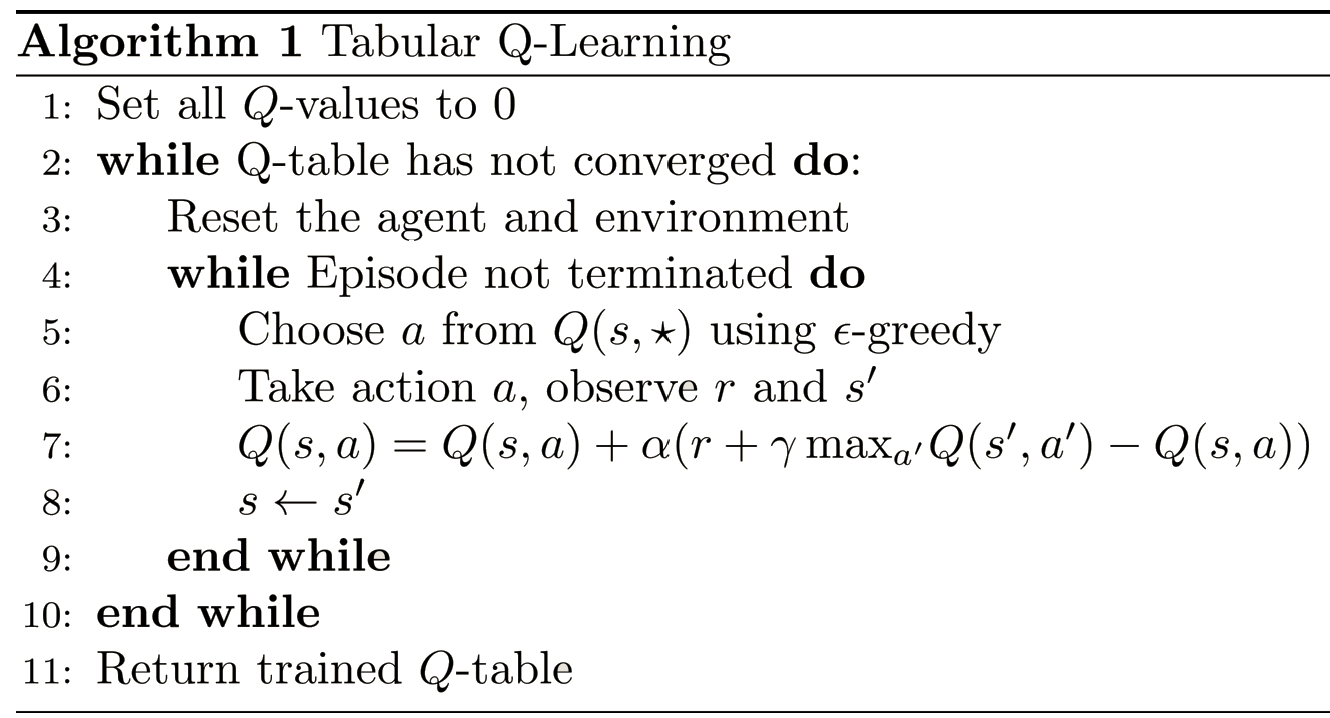

We are going to use Q-Learning to solve OpenAI Gym's `FrozenLakeNotSlippery-v0` environment.


In this environment, an agent needs to move across an icy lake which has holes in it.

At each timestep, the agent can move left, right, up, or down.

![Frozen lake image](https://www.gymlibrary.ml/_images/frozen_lake.gif)

>Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over the Frozen(F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.
> Source: https://www.gymlibrary.ml/environments/toy_text/frozen_lake/

For more details about custom environment creation and environment registration, please visit the `gym` docs:
* [Create a custom environment](https://www.gymlibrary.ml/content/environment_creation/?highlight=gym%20env%20registration%20register#environment-creation)
* [Register an environment](https://www.gymlibrary.ml/content/environment_creation/?highlight=gym%20env%20registration%20register#registering-envs)


Don't worry too much about this step, but we'll need to "register" the environment with `gym` and specify some parameters to run the simulation.

  * map_name: ID to use any of the preloaded maps.
    * "4x4"
      * values = [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
    ]

  * is_slippery: True/False. If True will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.
    * False


In [ ]:
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)

env = gym.make("FrozenLakeNotSlippery-v0")

Running the next cell starts a simulation which you can manaually step through (map steps shown above and in the console output) using the provided direction arguments. See if you can get to the goal state.

In [ ]:
# Pick 1,d,r,u to manually interact with the FrozenLake environment. Try to get
#   to the Goal (G) state to win.
# L = Left
# D = Down
# R = Right

# U = Up
directions = {'l': 0, 'd': 1, 'r': 2, 'u': 3}

# Reset the environment
env.reset()

# Run the environment until episode finishes
episode_over = False
while episode_over is False:
  clear_output()
  env.render()
  key = input("Next action (q to quit): ")
  if key == 'q':
    break
  _, reward, episode_over, _ = env.step(int(directions[key]))

print("Finished with reward: ", reward)

  (Down)
SFFF
FHFH
FFFH
HFFG
Next action (q to quit): d
Finished with reward:  0.0


Now that we've manually interacted with the simulation, let's use Q-learning to solve for reaching the goal state. 

The algorithm will initialize a Q-value table of all zeros.

After training, the Q-value table will store the estimated values for taking particular actions in particular states.

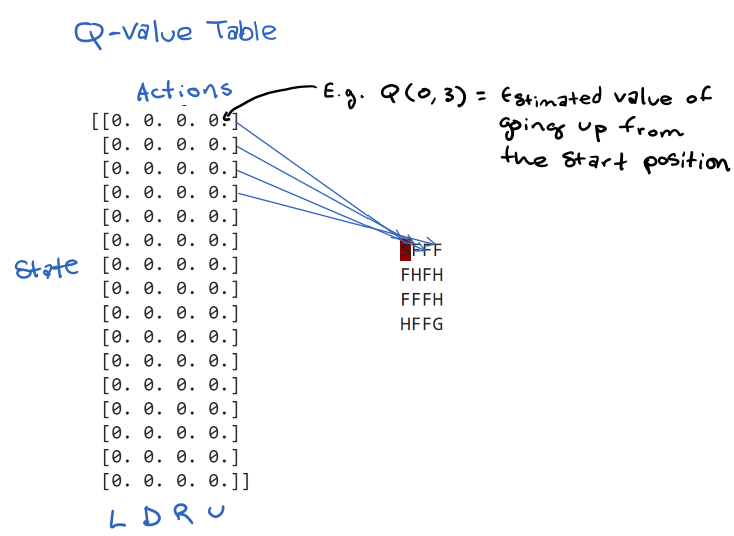

Here's a function to help you run the Q-Learning algorithm:

$Q(s,a) = Q(s,a) + \alpha(r + \gamma \max_{a'} Q(s',a') - Q(s,a))$

In [ ]:
def q_learning_algorithm(epsilon, alpha, gamma, num_episodes):
  # Get number of states and actions for the `FrozenLake-v0` environment.
  number_of_states = env.observation_space.n
  number_of_actions = env.action_space.n
  # Set the exploration probability
  ϵ = epsilon
  # Set the step size (aka learning rate)
  𝜶 = alpha
  # Set the discount factor for future rewards
  𝛄 = gamma
  # Initialize Q-values
  Q = np.zeros([number_of_states, number_of_actions])
  # Track reward history for plotting
  training_reward_history = []
  num_episodes = num_episodes
  for i_episode in range(num_episodes):
    # resets the environment
    state = env.reset()
    while True:
      rand = np.random.rand()

      if rand > ϵ:      
        if (Q[state].sum() != 0):  
          action = np.argmax(Q[state])
        else:
          action = env.action_space.sample()
      else:
        action = env.action_space.sample()

      new_state, reward, done, _ = env.step(action)

      # Update Q-value for the state-action pair
      Q[state, action] = Q[state, action] + 𝜶*(reward + 𝛄*np.max(Q[new_state]) - Q[state, action])

      # Setting new state for next action
      state = new_state
      
      if done:
        training_reward_history.append(reward)
        break
      
  return Q, training_reward_history

Invoke the function and plot the results.

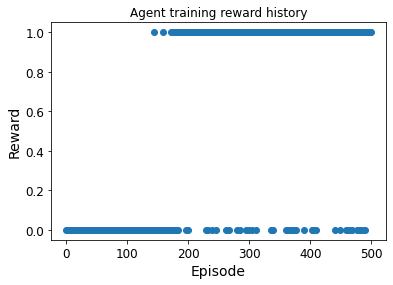

In [ ]:
Q, trh = q_learning_algorithm(epsilon=0.1, alpha=0.05, gamma=0.99, num_episodes=500)

# Visualize the rewards during training
plt.title('Agent training reward history')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(trh)), trh)


After training is finished, the Q-values table can be used to get the policy.

In [ ]:
print(Q)

[[1.67409000e-01 9.49191104e-01 7.85021717e-03 2.17223156e-01]
 [1.23107605e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.36707185e-01 9.59887966e-01 0.00000000e+00 1.43094584e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.72461235e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.01943335e-01 0.00000000e+00 9.70069312e-01 2.87726441e-01]
 [1.96108042e-01 9.80048878e-01 9.65469085e-02 0.00000000e+00]
 [0.00000000e+00 5.85621235e-01 0.00000000e+00 3.65878775e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.82994804e-01 9.89993049e-01 2.37158561e-01]
 [2.09547497e-01 4.22191202e-01 9.99999552e-01 1.50255412e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

Interesting that some Q-values are equal. (Recall the Q-value table has actions ordered as L, D, R, U.)

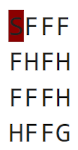

After training is finished, we can use the policy to simply "exploit" the environment. This environment is static, so online learning is not needed.

In [ ]:
for i_episode in range(5):
    
  # resets the environment
  print(f"Episode {i_episode} start")
  state = env.reset()
  env.render()
  time.sleep(2)
  clear_output()

  while True:
    action = np.argmax(Q[state])      
    new_state, reward, done, info = env.step(action)

    # Setting new state for next action
    state = new_state
    
    # Visualize the environment
    env.render()
    time.sleep(1)
    clear_output()

    if done:
      if reward == 1:
        print("You won!")
      else:
        print("You lost :(")
      time.sleep(2)
      clear_output()
      break

In the Q-Learning algorithm given above, the most important line is $Q(s,a) = Q(s,a) + \alpha(r + \gamma \max_{a'} Q(s',a') - Q(s,a))$. This is called a Temporal Difference method in RL, and it is an instance of Dynamic Programming.
* Note: Sam from Semiotic Labs only came to terms with that line by implementing a small environment by hand (e.g. 2 states and 2 actions) and manually calculating the Q-values. I have yet to implement the algorithm by hand 😅.

